In [1]:
#John Gizis
#Plot parallax observations for a given LSST simulation. adopted from Peter Yoachim's code at https://github.com/yoachim/LSST-BD-Cadence/blob/main/Pass_example.ipynb

#note this uses rubin_sim 

In [2]:

import rubin_sim.maf.utils as mafUtils

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import rubin_sim.maf.db as db
import rubin_sim.maf.utils as utils
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metricBundles as metricBundles
import rubin_sim.maf.plots as plots
import rubin_sim.maf.maps as maps


In [3]:
#choose location for plotting

#random spot in main survey
ra0=0
dec0=-20

# ...or...
#ra0=9.45
#dec0= -44
#This is a deep drilling field! ELIAS-S1

#or COSMOS DDF
#ra0=150.1
#dec0= 2.18

In [4]:
dbFile = '/sims_maf/fbs_1.7/rolling_nm/rolling_nm_scale1.0_nslice3_v1.7_10yrs.db' 
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='illustrate'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
bundleList = []
#sql = 'filter="z" or filter="y"'
sql = 'visitExposureTime > 14.'
metric = metrics.PassMetric(cols=['filter', 'fiveSigmaDepth', 'ra_pi_amp',
                                  'dec_pi_amp', 'seeingFwhmGeom','observationStartMJD'
                                 ])
slicer = slicers.UserPointsSlicer(ra=ra0, dec=dec0)
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             runName=runName))


In [6]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database SummaryAllProps with constraint visitExposureTime > 14. for columns ['fieldRA', 'rotSkyPos', 'observationStartMJD', 'filter', 'fieldDec', 'seeingFwhmGeom', 'fiveSigmaDepth']
Found 2042835 visits
Running:  ['_sims_maf_fbs_1_7_rolling_nm_rolling_nm_scale1_0_nslice3_v1_7_10yrs_Pass_filter_fiveSigmaDepth_ra_pi_amp_dec_pi_amp_seeingFwhmGeom_observationStartMJD_visitExposureTime_gt_14_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [7]:
bundleList[0].metricValues[0].dtype
dataSlice = bundleList[0].metricValues[0]

In [8]:
dataSlice.dtype


dtype([('fieldRA', '<f8'), ('rotSkyPos', '<f8'), ('observationStartMJD', '<f8'), ('filter', '<U256'), ('fieldDec', '<f8'), ('seeingFwhmGeom', '<f8'), ('fiveSigmaDepth', '<f8'), ('ra_pi_amp', '<f8'), ('dec_pi_amp', '<f8')])

In [9]:
# Here's the parallax amplitude. I'll just assume a 1" parallax star, but could multiply by any factor.
parallax_amplitude = (dataSlice['ra_pi_amp']**2 + dataSlice['dec_pi_amp']**2)**0.5
star_mag = 20.  # Just assume a flat SED. This is used in the estimate of the uncertainty.
snr = parallax_amplitude*0
atm_err = 0.01

for filt in np.unique(dataSlice['filter']):
    good = np.where(dataSlice['filter'] == filt)
    snr[good] = mafUtils.m52snr(star_mag, dataSlice['fiveSigmaDepth'][good])
position_errors = np.sqrt(mafUtils.astrom_precision(dataSlice['seeingFwhmGeom'],
                                                            snr)**2+atm_err**2)

Text(0, 0.5, 'Parallax Amplitude (arcsec)')

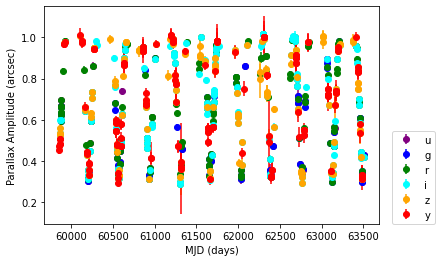

In [10]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}

for filt in 'ugrizy':
    good = np.where(dataSlice['filter'] == filt)
    plt.errorbar(dataSlice['observationStartMJD'][good], parallax_amplitude[good], yerr=position_errors[good],
                color=f2c[filt], fmt='o', label=filt)
plt.legend(loc=(1.04,0))
plt.xlabel('MJD (days)')
plt.ylabel('Parallax Amplitude (arcsec)')

In [11]:
izy = np.where((dataSlice['filter'] == 'z')|(dataSlice['filter'] == 'y'))
iz = np.where(dataSlice['filter'] == 'z')
iy = np.where(dataSlice['filter'] == 'y')
            

In [12]:
plot_base = """plot_rolling17_{plottype}_{ra}_{dec}.{ftype}"""


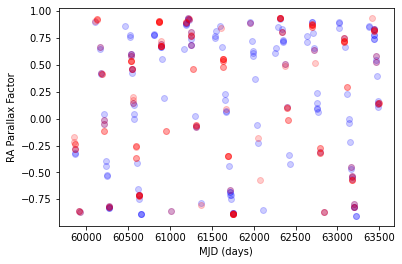

In [13]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='blue',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')   
plotname=plot_base.format(plottype='MJD_RAP',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)

In [14]:
days_since_start = dataSlice['observationStartMJD'] - np.min(dataSlice['observationStartMJD'])
years_since_start = days_since_start / 365.25636        #am I using right length of year? 
phase_years = years_since_start % 1

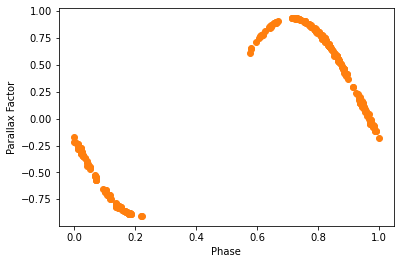

In [15]:
plt.plot(phase_years[izy],dataSlice['ra_pi_amp'][izy],'o',color='C1')
plt.xlabel('Phase')
plt.ylabel('Parallax Factor')   
plotname=plot_base.format(plottype='Phase_PF',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)


In [16]:
np.size(dataSlice['ra_pi_amp'][izy])

333

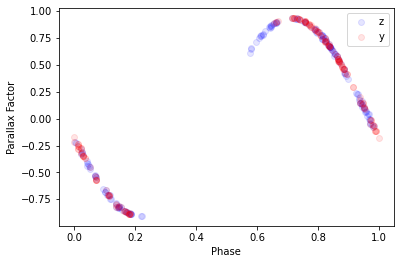

In [17]:
plt.plot(phase_years[iz],dataSlice['ra_pi_amp'][iz],'o',color='blue',alpha=0.1,label='z')
plt.plot(phase_years[iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.1,label='y')
plt.xlabel('Phase')
plt.ylabel('Parallax Factor');
plt.legend()
plotname=plot_base.format(plottype='Phase_PF',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)



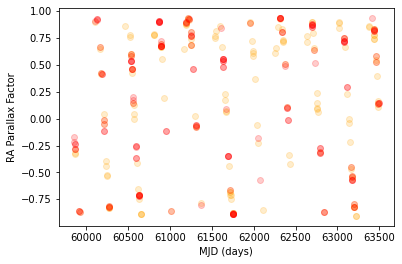

In [18]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='orange',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')  
plotname=plot_base.format(plottype='MJD_RAP_zy',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)




In [19]:
print(np.max(dataSlice['ra_pi_amp'][iy]),np.min(dataSlice['ra_pi_amp'][iy]))

0.9336609124213749 -0.885532222343434


In [20]:
from astropy.table import QTable, Table, Column
from astropy import units as u

In [21]:
parallax_table = Table()
parallax_table['MJD'] = dataSlice['observationStartMJD'][izy]
parallax_table['ra_pi_amp'] = dataSlice['ra_pi_amp'][izy]
parallax_table['dec_pi_amp'] = dataSlice['dec_pi_amp'][izy]
parallax_table['filter'] = dataSlice['filter'][izy]
parallax_table['seeingFWHM'] = dataSlice['seeingFwhmGeom'][izy]
parallax_table['snr'] = snr[izy]
parallax_table['position_errors'] = position_errors[izy]
parallax_table['fiveSigmaDepth'] = dataSlice['fiveSigmaDepth'][izy]
parallax_table['fieldRA'] = dataSlice['fieldRA'][izy]
parallax_table['fieldDec'] = dataSlice['fieldDec'][izy]




In [22]:
parallax_table

MJD,ra_pi_amp,dec_pi_amp,filter,seeingFWHM,snr,position_errors,fiveSigmaDepth,fieldRA,fieldDec
float64,float64,float64,str256,float64,float64,float64,float64,float64,float64
60575.29642658269,-0.0042675414642640895,-0.3548691734063136,z,0.6596213763165993,84.54759138600221,0.012683363514580888,23.070328088696655,359.0283267746269,-21.164935085489027
59857.21123871862,-0.21774123740345028,-0.4190458942620121,y,0.666860457479499,42.44957471719748,0.018622232654593663,22.322258348171744,358.1544351049139,-20.901611622065243
63195.12625109705,-0.8170389704836969,-0.4778422325825149,y,0.672781865511992,35.51479052887731,0.02142111387822756,22.12859813287745,358.2631433099932,-20.954600058535874
60546.33771177703,0.42111134431617575,-0.13761964305998947,z,0.8650754356966313,63.54379225442336,0.01689191573939977,22.760257813389995,358.1971180992317,-20.88023726940229
59865.190952771256,-0.3255709424110378,-0.4579057835970629,z,0.6049699108773777,94.16139139555499,0.011886054902453029,23.187257157475752,358.87456323809147,-21.18431493045681
63195.11003195097,-0.8169283356573254,-0.47788572521504574,z,0.634857665743433,71.21850390482767,0.0133963943566743,22.884057104561762,358.2631433099932,-20.954600058535874
61546.41656362713,0.8190410473727605,0.5009832735122356,z,1.020798519919817,45.337880221948964,0.02463617791379986,22.393728016095857,358.65238748196583,-21.13676820955291
63134.12890407899,-0.03700389133328612,-0.3783564392504463,z,0.6250183884018727,101.05560925457821,0.011758100740166547,23.263976051000054,359.3176395026223,-21.630407275646178
60864.27735865349,0.8977027992597176,0.2561022511120716,y,0.882474376267864,28.659280309767247,0.032375030085521186,21.895738189709185,359.12906526419636,-21.400937510097304


In [23]:
from astropy.io import ascii

In [24]:
out_base = """data_rolling17_{datatype}_{ra}_{dec}.{ftype}"""
outname_tbl=out_base.format(datatype='parallax',ra=ra0,dec=dec0,ftype='tbl')
outname_csv=out_base.format(datatype='parallax',ra=ra0,dec=dec0,ftype='csv')


In [25]:
#ascii.write(parallax_table,outname_tbl,format='ipac')

In [26]:
ascii.write(parallax_table,outname_csv,format='ecsv')

(array([1.30743924, 0.26148785, 0.42491775, 0.22880187, 0.22880187,
        0.22880187, 0.55566168, 0.26148785, 0.22880187, 0.45760373,
        0.35954579, 0.55566168, 0.13074392, 0.09805794, 0.45760373,
        0.65371962, 0.55566168, 1.14400933, 0.98057943, 1.76504297]),
 array([-0.90382594, -0.81195159, -0.72007725, -0.62820291, -0.53632857,
        -0.44445422, -0.35257988, -0.26070554, -0.1688312 , -0.07695685,
         0.01491749,  0.10679183,  0.19866617,  0.29054052,  0.38241486,
         0.4742892 ,  0.56616354,  0.65803789,  0.74991223,  0.84178657,
         0.93366091]),
 [<matplotlib.patches.Polygon at 0x7fe40b4cd0a0>])

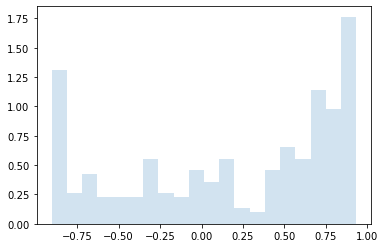

In [27]:
plt.hist(parallax_table['ra_pi_amp'],bins=20,histtype='stepfilled', alpha=0.2, density=True)


(array([0.001719  , 0.01088697, 0.01260597, 0.02120094, 0.03094192,
        0.01833595, 0.01661696, 0.00916798, 0.00916798, 0.00630298,
        0.01145997, 0.01088697, 0.00974097, 0.00859498, 0.00286499,
        0.00229199, 0.001719  , 0.00458399, 0.        , 0.001719  ]),
 array([ 10.32682459,  15.56768153,  20.80853846,  26.0493954 ,
         31.29025234,  36.53110928,  41.77196622,  47.01282316,
         52.25368009,  57.49453703,  62.73539397,  67.97625091,
         73.21710785,  78.45796479,  83.69882172,  88.93967866,
         94.1805356 ,  99.42139254, 104.66224948, 109.90310642,
        115.14396335]),
 [<matplotlib.patches.Polygon at 0x7fe40b4ac910>])

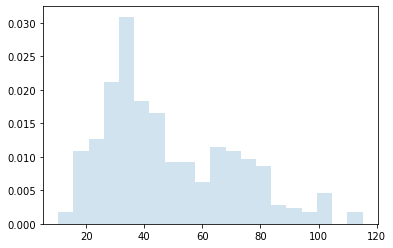

In [28]:
plt.hist(parallax_table['snr'],bins=20,histtype='stepfilled', alpha=0.2, density=True)



(array([0.02293957, 0.02293957, 0.        , 0.09175828, 0.25233527,
        0.16057699, 0.18351656, 0.41291226, 0.59642883, 0.8487641 ,
        0.89464324, 0.6193684 , 0.55054968, 0.48173097, 0.38997269,
        0.64230797, 0.82582453, 0.25233527, 0.25233527, 0.13763742]),
 array([20.78749199, 20.91840129, 21.04931058, 21.18021988, 21.31112918,
        21.44203847, 21.57294777, 21.70385707, 21.83476636, 21.96567566,
        22.09658496, 22.22749425, 22.35840355, 22.48931285, 22.62022214,
        22.75113144, 22.88204074, 23.01295003, 23.14385933, 23.27476863,
        23.40567792]),
 [<matplotlib.patches.Polygon at 0x7fe40b40a3a0>])

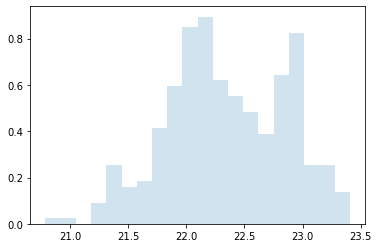

In [29]:
plt.hist(parallax_table['fiveSigmaDepth'],bins=20,histtype='stepfilled', alpha=0.2, density=True)

